## Mod3 Project Submission

- Student name: Juliette Cabrera
- Student pace: Part-Time
- Scheduled project review date/time: December 13, 2019/6:30pm
- Instructor name: Matt Sparr
- Blog post URL:

# The Problem: Increasing Revenue - Hypothesis Testing 

###  The Questions:
1. Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?
2. Do suppliers from some regions generate more revenue than others?  Is the revenue different for the different types of categories being supplied?  Is the average revenue from a supplier in a certain region different depending on the category that it is supplying?
3. Do employees from USA or the UK generate more revenue?  Do some employees generate more revenue than others?  If so, which employees?  Does their title affect their sales in any way?
4. Do some categories of product sell more during certain seasons?  If so, which categories?

## Steps taken for each question stated above:
- Define the hypothesis. 
- Explore the given SQL data.
- Test the hypothesis.
- Interpert the findings.

# The Northwind Database

![](Northwind_ERD_updated.png)

# 1. Importing the SQL Northwind Data, libraries, and defining functions:

In [1]:
# import the necessary libraries
import sqlite3
import pandas as pd
import numpy as np
from numpy import mean, sqrt, std

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

import scipy.stats as stats
import statsmodels.api as sm

from statsmodels.stats.power import tt_ind_solve_power

from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.graphics.factorplots import interaction_plot

In [2]:
# import the SQL data
conn = sqlite3.connect('Northwind_small.sqlite')
cur=conn.cursor()

In [3]:
# add column revenue column to 'OrderDetail' table - only needs to be run once
# cur.execute("""ALTER TABLE OrderDetail             
#                ADD Revenue money;""")

In [4]:
# add values to the new 'revenue' column in the 'OrderDetail' table
cur.execute("""UPDATE OrderDetail
               SET Revenue = (UnitPrice*Quantity)-(UnitPrice*Quantity*Discount)""")

In [5]:
# defining effect size function - Cohen's D
def cohens_d_one_sample(x, mu0):
    return (x.mean()-mu0)/x.std()

def cohen_d_two_samp(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return np.abs((mean(x) - mean(y))/sqrt(((nx-1)*std(x,ddof=1)**2+(ny-1)*std(y, ddof=1)**2)/dof))

___

# 2. Diving In

## Question 1a: 
- Does discount amount have a statistically significant effect on the quantity of a product in an order? 

###  Define the hypothesis
- H$_{0}$: Discount amount **does not** have a statistically significant effect on the quantity of a product in an order.
- H$_{a}$: Discount amount **does** have a statistically significant effect on the quantity of a product in an order.
- $\alpha$ = 0.05 

### Explore the Data

- #### Check the OrderDetail table, which through the schema that Northwind has provided, is where we can find the discounts.

In [6]:
cur.execute("""SELECT *
               FROM OrderDetail
               """)
orderdetail = pd.DataFrame(cur.fetchall())
orderdetail.columns = [x[0] for x in cur.description]
display(orderdetail.head())
len(orderdetail)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Revenue
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


2155

In [7]:
cur.execute("""SELECT *
               FROM OrderDetail
               WHERE Discount = 0""")
orderdetail_nodiscount = pd.DataFrame(cur.fetchall())
orderdetail_nodiscount.columns = [x[0] for x in cur.description]
display(orderdetail_nodiscount.head())
len(orderdetail_nodiscount)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Revenue
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


1317

In [8]:
cur.execute("""SELECT *
               FROM OrderDetail
               WHERE Discount > 0""")
orderdetail_discount = pd.DataFrame(cur.fetchall())
orderdetail_discount.columns = [x[0] for x in cur.description]
display(orderdetail_discount.head())
len(orderdetail_discount)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Revenue
0,10250/51,10250,51,42.4,35,0.15,1261.40
1,10250/65,10250,65,16.8,15,0.15,214.20
2,10251/22,10251,22,16.8,6,0.05,95.76
3,10251/57,10251,57,15.6,15,0.05,222.30
4,10252/20,10252,20,64.8,40,0.05,2462.40


838

- #### The question is asking about the effect on the quantity of a product in an order.  From the OrderDetail table, group by the orders that were placed, find the total number of products that were placed in that order, and average the discount that was used for that particular order.

In [9]:
cur.execute("""SELECT OrderId, Sum(Quantity) as Total_Quantity, AVG(Discount) as Average_Discount 
            FROM OrderDetail
            GROUP BY OrderId""")
general_discounts = pd.DataFrame(cur.fetchall())
general_discounts.columns = [x[0] for x in cur.description]
general_discounts.head()

,OrderId,Total_Quantity,Average_Discount
0,10248,27,0.000000
1,10249,49,0.000000
2,10250,60,0.100000
3,10251,41,0.033333
4,10252,105,0.033333


- #### The hypothesis is testing the effect of having and not having a discount, the dataframe needs to be separated.  Not having a discount ( == 0) and having a discount (!= 0).

In [10]:
no_discount = general_discounts[general_discounts['Average_Discount'] == 0]
discount = general_discounts[general_discounts['Average_Discount']!= 0]

### Testing the hypothesis

- #### Plot the distributions of the quantity of each dataframe (no_discount and discount)

/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


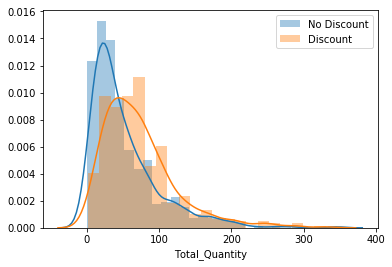

In [11]:
sns.distplot(no_discount['Total_Quantity'], label='No Discount')
sns.distplot(discount['Total_Quantity'], label='Discount')
plt.legend();

- #### Since the distribution is a nonparametric distribution, the test to check for the p-value is the Mann Whitney U test.

In [12]:
t, p = stats.mannwhitneyu(no_discount['Total_Quantity'], discount['Total_Quantity'])
print('p-value:', p)

p-value: 8.524065415288705e-15


- #### The p-value is less than the alpha of 0.05, this means that the null hypothesis is rejected and the alternative hypothesis is accepted.  The alternative hypothesis states, that discount does have a statistically significant effect on the quantity of a product on an order.  The next step will be to find the effect size.  

- #### It is important to state that an effect size:
    - equal to 0.2 is a small effect
    - equal to 0.5 is a medium effect
    - equal to 0.8 is a large effect

In [13]:
effect_size_discounts = cohen_d_two_samp(discount['Total_Quantity'], no_discount['Total_Quantity'])
print('Effect size is', round(effect_size_discounts, 2))

Effect size is 0.41


- #### After finding the effect size, next calculate the power.  Power is the probability of not making a Type II error.

In [14]:
tt_ind_solve_power(effect_size_discounts, len(general_discounts), 0.05)

1.0

- #### The power here shows that there is a zero chance of committing a type II error.  A type II error is the probability of rejecting the null hypothesis, when in fact it should have been failed to reject the null hypothesis.

## Question 1b:
- If so, at what level(s) of discount?

### Define the hypothesis
- H$_{0}$: There **is no** difference between the level(s) of discount.
- H$_{a}$: There **is** a difference between the level(s) of discount.
- $\alpha$ = 0.05 

### Testing the hypothesis

- #### The question is asking to only look at the certain discounts from the original data, not including no discounts.  To compare the quantity with discounts, the ANOVA test is used.

In [15]:
sm.stats.anova_lm(ols('Quantity ~ Discount', data=orderdetail_discount).fit())

,df,sum_sq,mean_sq,F,PR(>F)
Discount,1.0,381.770455,381.770455,0.884727,0.347182
Residual,836.0,360744.129306,431.512116,NaN,NaN


- #### The ANOVA test shows that the p-value is greater than the defined alpha of .05, this means that we fail to reject the null hypothesis, therefore no particular discount has an effect on the quantity of the order.

### Interpretation of the findings

- The hypothesis tests first showed that we rejected the null hypothesis and accepted the alternative hypothesis that states that discount does have a statistically significant effect on the quantity of a product in an order.  
- The effect size is 0.41, which means that there is a small to medium effect.  This means that a discount has a small to medium effect on the quantity of products being purchased.
- The power showed that it was correct in rejecting the null hypothesis, because it showed a zero chance of committing a type II error.
- When it came to the different level(s) of discounts, the ANOVA test showed that there is no significant difference between the discounts.
- Placing discounts when orders that go over a certain quantity allows for customers to buy more products -- increasing revenue.  The different levels of discounts did not effect the quantity of orders, therefore, Northwind should have one discount across the board. 
- Suggestion: Northwind should offer discounts when an order quantity exceeds 60 for a 5% discount.

## Question 2a:
- Do suppliers from some regions generate more revenue than others?

###  Define the hypothesis
- H$_{0}$: Suppliers from some regions **do not** generate more revenue than others.
- H$_{a}$: Suppliers from some regions **do** generate more revenue than others.
- $\alpha$ = 0.05 

### Explore the Data

- #### Looking through the schema provided, the information that is needed is the Suppliers and the OrderDetails, to see the revenue.  The tables that need to be joined are the Supplier, Product, and OrderDetail tables, in order to see the information to answer this question.  From there, the columns are refined to just the necessary items of Region and Revenue.

In [16]:
cur.execute("""SELECT Region, Revenue
               FROM Supplier s
               JOIN Product p
               ON s.Id = p.SupplierId
               JOIN OrderDetail od
               ON p.Id = od.ProductId
               """)
supplier_product_od = pd.DataFrame(cur.fetchall())
supplier_product_od.columns = [x[0] for x in cur.description]
display(supplier_product_od.head())
len(supplier_product_od)

,Region,Revenue
0,Southern Europe,168.0
1,South-East Asia,98.0
2,Southern Europe,174.0
3,Eastern Asia,167.4
4,NSW,1696.0


2155

### Testing the hypothesis

- #### The question asks to compare the different regions with their revenues, therefore the ANOVA test is used.

In [17]:
sm.stats.anova_lm(ols('Revenue ~ Region', data=supplier_product_od).fit())

,df,sum_sq,mean_sq,F,PR(>F)
Region,10.0,1.539531e+08,1.539531e+07,17.655769,2.802947e-31
Residual,2144.0,1.869505e+09,8.719706e+05,NaN,NaN


- #### The ANOVA test shows that the p-value is less than the defined alpha of .05, this means that we reject the null hypothesis and accept the alternative hypothesis that suppliers from different regions lead to higher revenue. 
- #### To see where the differences are, the Tukey HSD test is used.

In [18]:
tukey_results_region = pairwise_tukeyhsd(supplier_product_od['Revenue'], supplier_product_od['Region'])
tukey_results_region.summary()

group1,group2,meandiff,lower,upper,reject
British Isles,Eastern Asia,23.8529,-318.537,366.2427,False
British Isles,NSW,313.1516,-52.2706,678.5739,False
British Isles,North America,135.9445,-114.6761,386.565,False
British Isles,Northern Europe,-46.6002,-363.3404,270.14,False
British Isles,Scandinavia,52.5435,-252.2277,357.3148,False
British Isles,South America,-268.1884,-735.8094,199.4326,False
British Isles,South-East Asia,155.901,-233.4049,545.207,False
British Isles,Southern Europe,183.3999,-100.6534,467.4533,False
British Isles,Victoria,296.6182,-14.3386,607.575,False
British Isles,Western Europe,706.1398,458.3385,953.9412,True


/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


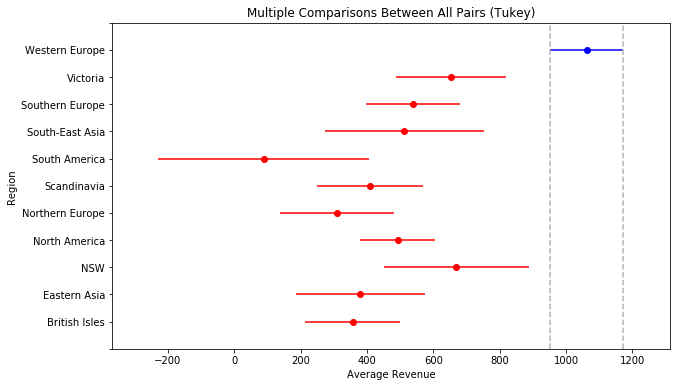

In [19]:
tukey_results_region.plot_simultaneous(comparison_name='Western Europe', ylabel='Region', xlabel='Average Revenue').show()

In [20]:
WE = supplier_product_od[supplier_product_od['Region']=='Western Europe']
no_WE = supplier_product_od[supplier_product_od['Region']!='Western Europe']

In [21]:
effect_size_region = cohen_d_two_samp(WE, no_WE)
print('Effect size is', round(effect_size_region, 2))

Effect size is Revenue    0.64
dtype: float64


- #### It is important to state that an effect size:
    - equal to 0.2 is a small effect
    - equal to 0.5 is a medium effect
    - equal to 0.8 is a large effect

In [22]:
tt_ind_solve_power(effect_size=effect_size_region, nobs1=len(supplier_product_od), alpha=0.05)

Revenue    1.0
dtype: float64

## Question 2b:
- Is the revenue different for the different types of categories being supplied?

###  Define the hypothesis
- H$_{0}$: Different category types supplied **does not** change the revenue generated for Northwind.
- H$_{a}$: Different category types supplied **does** change the revenue generated for Northwind.
- $\alpha$ = 0.05 

### Explore the Data

- #### For this question, the Category table needs to be joined with the tables from part a.  The information being compared is the category of the foods being supplied and the revenue that those categories bring in.

In [23]:
cur.execute("""SELECT CategoryName, Region, Revenue
               FROM Supplier s
               JOIN Product p
               ON s.Id = p.SupplierId
               JOIN Category c
               ON p.CategoryId = c.Id
               JOIN OrderDetail od
               ON p.Id = od.ProductId
               """)
supplier_category = pd.DataFrame(cur.fetchall())
supplier_category.columns = [x[0] for x in cur.description]
display(supplier_category.head())
len(supplier_category)

,CategoryName,Region,Revenue
0,Dairy Products,Southern Europe,168.0
1,Grains/Cereals,South-East Asia,98.0
2,Dairy Products,Southern Europe,174.0
3,Produce,Eastern Asia,167.4
4,Produce,NSW,1696.0


2155

### Testing the hypothesis

- #### Same as above, the question is asking to compare the category types with their revenue, so the ANOVA test is used.

In [24]:
sm.stats.anova_lm(ols('Revenue ~ CategoryName', data=supplier_category).fit())

,df,sum_sq,mean_sq,F,PR(>F)
CategoryName,7.0,4.639896e+07,6.628422e+06,7.198177,1.536802e-08
Residual,2147.0,1.977059e+09,9.208473e+05,NaN,NaN


- #### The ANOVA test shows that the p-value is less than the defined alpha of .05, this means that we reject the null hypothesis and accept the alternative hypothesis that there is a category type that changes the revenue generated for Northwind. 
- #### To see where the differences are, the Tukey HSD test is used.

In [25]:
tukey_category = pairwise_tukeyhsd(supplier_category['Revenue'], supplier_category['CategoryName'])
tukey_category.summary()

group1,group2,meandiff,lower,upper,reject
Beverages,Condiments,-172.0813,-417.4777,73.315,False
Beverages,Confections,-161.9705,-377.2755,53.3345,False
Beverages,Dairy Products,-22.3098,-232.3991,187.7796,False
Beverages,Grains/Cereals,-174.5473,-427.9707,78.8762,False
Beverages,Meat/Poultry,279.2857,14.7624,543.8091,True
Beverages,Produce,72.1407,-216.4794,360.7608,False
Beverages,Seafood,-265.2772,-481.2954,-49.2591,True
Condiments,Confections,10.1108,-244.0866,264.3082,False
Condiments,Dairy Products,149.7716,-100.0235,399.5667,False
Condiments,Grains/Cereals,-2.4659,-289.6653,284.7335,False


/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


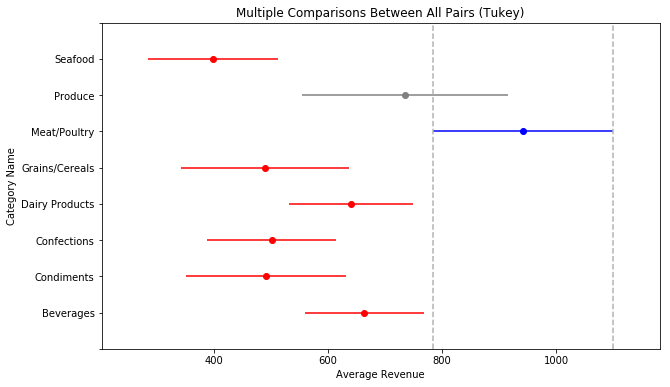

In [26]:
tukey_category.plot_simultaneous(comparison_name='Meat/Poultry', ylabel='Category Name', xlabel='Average Revenue').show()

In [27]:
meat = supplier_category[supplier_category['CategoryName']=='Meat/Poultry']
no_meat = supplier_category[supplier_category['CategoryName']!='Meat/Poultry']

In [28]:
effect_size_category = cohen_d_two_samp(meat, no_meat)
print('Effect size is', round(effect_size_category, 2))

Effect size is Revenue    0.4
dtype: float64


- #### It is important to state that an effect size:
    - equal to 0.2 is a small effect
    - equal to 0.5 is a medium effect
    - equal to 0.8 is a large effect

In [29]:
tt_ind_solve_power(effect_size=effect_size_category, nobs1=len(supplier_category), alpha=0.05)

Revenue    1.0
dtype: float64

## Question 2c:
- Is the average revenue from a supplier in a certain region different depending on the category that it is supplying?

### Define the hypothesis
- H$_{0}$: There **is no** difference in revenue from suppliers in different regions depending on category type.
- H$_{a}$: There **is** a difference in revenue from suppliers in different regions depending on category type.
- $\alpha$ = 0.05 

### Testing the hypothesis

- #### The question is asking to compare the category types in certain regions with their revenue, so the ANOVA test is used.

In [30]:
sm.stats.anova_lm(ols('Revenue ~ Region*CategoryName', data=supplier_category).fit())

,df,sum_sq,mean_sq,F,PR(>F)
Region,10.0,1.539531e+08,1.539531e+07,19.846453,1.909393e-35
CategoryName,7.0,3.381987e+07,4.831411e+06,6.228283,3.044388e-07
Region:CategoryName,70.0,2.050450e+08,2.929215e+06,3.776118,1.563310e-22
Residual,2114.0,1.639874e+09,7.757211e+05,NaN,NaN


- #### The ANOVA test shows that the p-value is less than the defined alpha of .05, this means that we reject the null hypothesis and accept the alternative hypothesis that there is a difference in revenue from suppliers in different regions depending on their category type.
- #### To see where the differences are, the Tukey HSD test is used.

In [31]:
tukey_sup_cat = pairwise_tukeyhsd(supplier_category['Revenue'], supplier_category['Region']+supplier_category['CategoryName'])
tukey_sup_cat.summary()

group1,group2,meandiff,lower,upper,reject
British IslesBeverages,British IslesCondiments,-101.7487,-1164.7849,961.2875,False
British IslesBeverages,British IslesConfections,11.6003,-476.4011,499.6018,False
British IslesBeverages,Eastern AsiaCondiments,-57.9445,-1512.5341,1396.645,False
British IslesBeverages,Eastern AsiaMeat/Poultry,1089.8846,-494.4589,2674.2282,False
British IslesBeverages,Eastern AsiaProduce,-57.5871,-752.0254,636.8512,False
British IslesBeverages,Eastern AsiaSeafood,-1.6102,-555.0611,551.8408,False
British IslesBeverages,NSWGrains/Cereals,-243.9343,-987.0172,499.1485,False
British IslesBeverages,NSWMeat/Poultry,330.3903,-403.4864,1064.2671,False
British IslesBeverages,NSWProduce,716.8834,47.8695,1385.8972,True
British IslesBeverages,North AmericaBeverages,-10.9354,-582.1203,560.2496,False


/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


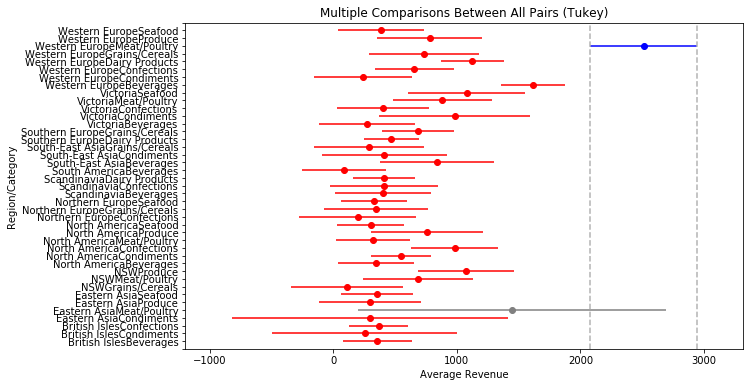

In [32]:
tukey_sup_cat.plot_simultaneous(comparison_name='Western EuropeMeat/Poultry', ylabel='Region/Category', xlabel='Average Revenue').show()

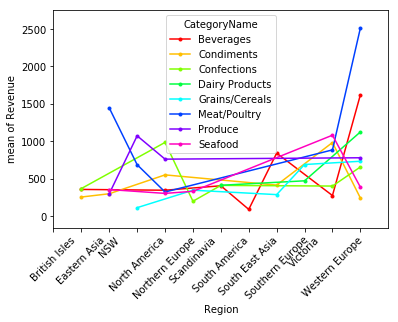

In [33]:
interaction_plot(response=supplier_category['Revenue'], trace=supplier_category['CategoryName'], x=supplier_category['Region'].astype('category').cat.codes)
plt.xlabel('Region')
xlabels = ['British Isles', 'Eastern Asia', 'NSW', 'North America', 'Northern Europe', 'Scandinavia', 'South America', 'South East Asia', 'Southern Europe', 'Victoria', 'Western Europe']
xvalues = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.xticks(xvalues, xlabels)
plt.tick_params(axis ='x', rotation = 45)
plt.show();



- **Note:** Region
    - 0 is British Isles
    - 1 is Eastern Asia
    - 2 is NSW
    - 3 is North America 
    - 4 is Northen Europe
    - 5 is Scandinavia
    - 6 is South America
    - 7 is South East Asia
    - 8 is Southern Europe
    - 9 is Victoria
    - 10 is Western Europe

### Interpretation of the findings

- Western Europe supplies the products that lead to higher revenue.
    - The effect size for this is 0.64, which is a medium effect, this means that the region has a significant effect on the revenue generated.
    - The power showed that it was correct in rejecting the null hypothesis, because it showed a zero chance of committing a type II error.
- The type of category being supplied does change the revenue that is being generated.  
    - This shows that the seafood category generally makes the least revenue but may not be statistically different from grains/cereals, confections, and condiments.
    - The meat/poultry category makes the most revenue, with an effect size of 0.4. But may not be statistically different than produce.
        - An effect size of 0.4 is a small to medium effect, which means that the meat/poultry category has a significant effect on the revenue that Northwind generates.
    - The power showed that it was correct in rejecting the null hypothesis, because it showed a zero chance of committing a type II error.
- The highest revenue comes from Western Europe supplying Meat/Poultry products.
    - Meat/Poultry products are a popular product to supply because it brings in the most revenue.  Western Europe supplies the product that generates the most money, but is may not be statiscally different than when East Asia is supplying the product.
- Suggestion: Northwind should stop asking Western Europe to supply seafood since that generates the least amount of revenue and focus on developing their Meat/Poultry division.  Something else that this data shows is the Bristish Isles supplies Northwind with only three categories of products, that make the least amount of revenue overall for the company -- Bristish Isles suppliers are costing Northwind money but note producing products that customers want to buy.

## Question 3a:
- Do employees from the USA or UK generate more revenue for Northwind? 

### Define the hypothesis
- H$_{0}$: There **is no** difference in revenue from employees in the US and employees in the UK.
- H$_{a}$: There **is** a difference in revenue from employees in the US and employees in the UK.
- $\alpha$ = 0.05 

### Explore the Data

- #### Looking at the schema of the Northwind data, in order to see the employees revenue, three tables need to be joined.  Employee, Orders, and OrderDetail.  To organize the data properly, the OrderId's will be grouped together, since an employee can place many products under one order.  The sum of that order will be considered the revenue.

- #### USA Employees ONLY

In [34]:
cur.execute("""SELECT Title, e.Id, FirstName, City, Region, Country, SUM(od.Revenue) as Revenue
               FROM Employee e
               JOIN [Order] o
               ON e.Id = o.EmployeeId
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               WHERE Country = 'USA'
               GROUP BY OrderId
               """)
employee_usa = pd.DataFrame(cur.fetchall())
employee_usa.columns = [x[0] for x in cur.description]
display(employee_usa.head())
len(employee_usa)

,Title,Id,FirstName,City,Region,Country,Revenue
0,Sales Representative,4,Margaret,Redmond,North America,USA,1552.60
1,Sales Representative,3,Janet,Kirkland,North America,USA,654.06
2,Sales Representative,4,Margaret,Redmond,North America,USA,3597.90
3,Sales Representative,3,Janet,Kirkland,North America,USA,1444.80
4,Sales Representative,3,Janet,Kirkland,North America,USA,517.80


606

- #### UK Employees ONLY

In [35]:
cur.execute("""SELECT Title, e.Id, FirstName, City, Region, Country, SUM(od.Revenue) as Revenue
               FROM Employee e
               JOIN [Order] o
               ON e.Id = o.EmployeeId
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               WHERE Country = 'UK'
               GROUP BY OrderID
               """)
employee_uk = pd.DataFrame(cur.fetchall())
employee_uk.columns = [x[0] for x in cur.description]
display(employee_uk.head())
len(employee_uk)

,Title,Id,FirstName,City,Region,Country,Revenue
0,Sales Manager,5,Steven,London,British Isles,UK,440.00
1,Sales Representative,6,Michael,London,British Isles,UK,1863.40
2,Sales Manager,5,Steven,London,British Isles,UK,556.62
3,Sales Representative,9,Anne,London,British Isles,UK,2490.50
4,Sales Representative,9,Anne,London,British Isles,UK,1873.80


224

### Testing the hypothesis

- #### Plot the distributions of the revenue of each dataframe (USA employees and UK employees)

/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


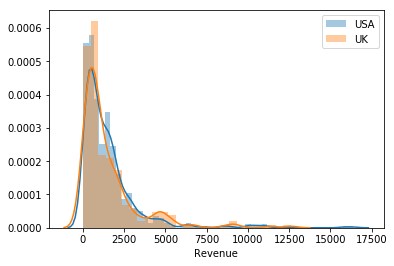

In [36]:
sns.distplot(employee_usa['Revenue'], label='USA')
sns.distplot(employee_uk['Revenue'], label='UK')
plt.legend();

- #### Since the distribution is a nonparametric distribution, the test to check for the p-value is the Mann Whitney U test.

In [37]:
t, p = stats.mannwhitneyu(employee_usa['Revenue'],employee_uk['Revenue'])
print('p-value:', p)

p-value: 0.23196500058765546


- #### The p-value is greater than the alpha of 0.05, this means that we fail to reject null hypothesis and the alternative hypothesis cannot be accepted.

## Question 3b/c:
- Do some employees generate more revenue than others? If so, which employees?

### Define the hypothesis
- H$_{0}$: There **is no** difference in revenue generated by Northwind emmployees.
- H$_{a}$: There **is** a difference in revenue generated by Northwind employees.
- $\alpha$ = 0.05

### Explore the Data

- #### Looking at the schema of the Northwind data, in order to see the employees revenue, three tables need to be joined.  Employee, Orders, and OrderDetail.  This time, the data is not separated by Country.

In [38]:
cur.execute("""SELECT OrderId, Title, e.Id, FirstName, City, Region, Country, SUM(od.Revenue) as Total_Revenue
               FROM Employee e
               JOIN [Order] o
               ON e.Id = o.EmployeeId
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               GROUP BY OrderId
               """)
employee_us_uk = pd.DataFrame(cur.fetchall())
employee_us_uk.columns = [x[0] for x in cur.description]
display(employee_us_uk.head())
len(employee_us_uk)

,OrderId,Title,Id,FirstName,City,Region,Country,Total_Revenue
0,10248,Sales Manager,5,Steven,London,British Isles,UK,440.00
1,10249,Sales Representative,6,Michael,London,British Isles,UK,1863.40
2,10250,Sales Representative,4,Margaret,Redmond,North America,USA,1552.60
3,10251,Sales Representative,3,Janet,Kirkland,North America,USA,654.06
4,10252,Sales Representative,4,Margaret,Redmond,North America,USA,3597.90


830

### Testing the hypothesis

In [39]:
sm.stats.anova_lm(ols('Total_Revenue ~ FirstName', data=employee_us_uk).fit())

,df,sum_sq,mean_sq,F,PR(>F)
FirstName,8.0,3.358256e+07,4.197821e+06,1.23576,0.274783
Residual,821.0,2.788901e+09,3.396956e+06,NaN,NaN


- #### The p-value is greater than the alpha of 0.05, this means that we fail to reject null hypothesis and the alternative hypothesis cannot be accepted.

## Question 3d:
- Does their title effect their sales in any way?

### Define the hypothesis
- H$_{0}$: There **is no** effect on sales due to employee titles.
- H$_{a}$: There **is** an effect on sales due to employee titles.
- $\alpha$ = 0.05

### Testing the hypothesis

- #### The question asks to compare the different employee titles with their revenues, therefore the ANOVA test is used.

In [40]:
sm.stats.anova_lm(ols('Total_Revenue ~ Title*FirstName', data=employee_us_uk).fit())

,df,sum_sq,mean_sq,F,PR(>F)
Title,3.0,1.452612e+07,4.842039e+06,1.425406,0.233969
FirstName,8.0,2.168666e+07,2.710832e+06,0.798018,0.604451
Title:FirstName,24.0,2.288100e+07,9.533750e+05,0.280656,0.999777
Residual,821.0,2.788901e+09,3.396956e+06,NaN,NaN


- #### The p-value is greater than the alpha of 0.05, this means that we fail to reject null hypothesis and the alternative hypothesis cannot be accepted.

### Interpretation of the findings

- For all three questions we failed to reject the null hypothesis.
    - Employees in both the USA and UK generate the same amount of money for Northwind.
    - No employee generates more or less money than another.
- Suggestion: This shows that Northwind is able to keep their employees where they are and save money by not needing to retrain, hire, or let anyone go.

## Question 4:
-  Do some categories of product sell more during certain seasons? If so, which categories?

### Define the hypothesis
- H$_{0}$: Season **does not** effect categories of product purchases.
- H$_{a}$: Season **does** effect categories of product purchases.
- $\alpha$ = 0.05

### Explore the Data

- #### Looking through the Northwind schema, there were four tables that needed to be joined in order to get the information needed to answer this question.  They were the Order, OrderDetail, Product, and Catgory tables.  The important information needed in the table was the category name and the revenue that it made. Then the information needed to be separated by season.
    - #### Seasons as per google:
        - #### Spring: March 1 - May 31
        - #### Summer: June 1 - August 31
        - #### Fall: September 1 - November 30
        - #### Winter: December 1 - Feburary 28

- #### Summer Only

In [41]:
cur.execute("""SELECT OrderDate, CategoryName, od.Revenue
               FROM [Order] o
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               JOIN Product p
               ON od.ProductId = p.Id
               JOIN Category c
               ON p.CategoryId = c.Id
               WHERE OrderDate BETWEEN '2012-07-01' AND '2012-09-31'
               ORDER BY OrderDate ASC""")
summer2012 = pd.DataFrame(cur.fetchall())
summer2012.columns = [x[0] for x in cur.description]
display(summer2012.head())

,OrderDate,CategoryName,Revenue
0,2012-07-04,Dairy Products,168.0
1,2012-07-04,Grains/Cereals,98.0
2,2012-07-04,Dairy Products,174.0
3,2012-07-05,Produce,167.4
4,2012-07-05,Produce,1696.0


In [42]:
cur.execute("""SELECT OrderDate, CategoryName, od.Revenue
               FROM [Order] o
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               JOIN Product p
               ON od.ProductId = p.Id
               JOIN Category c
               ON p.CategoryId = c.Id
               WHERE OrderDate BETWEEN '2013-07-01' AND '2013-09-31'
               ORDER BY OrderDate ASC""")
summer2013 = pd.DataFrame(cur.fetchall())
summer2013.columns = [x[0] for x in cur.description]
display(summer2013.head())

,OrderDate,CategoryName,Revenue
0,2013-07-01,Confections,142.50
1,2013-07-02,Grains/Cereals,23.80
2,2013-07-02,Confections,187.38
3,2013-07-02,Beverages,360.00
4,2013-07-02,Condiments,260.00


- #### Spring Only

In [43]:
cur.execute("""SELECT OrderDate, CategoryName, od.Revenue
               FROM [Order] o
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               JOIN Product p
               ON od.ProductId = p.Id
               JOIN Category c
               ON p.CategoryId = c.Id
               WHERE OrderDate BETWEEN '2013-03-01' AND '2013-05-31'
               ORDER BY CategoryName""")
spring2013 = pd.DataFrame(cur.fetchall())
spring2013.columns = [x[0] for x in cur.description]
display(spring2013.head())

,OrderDate,CategoryName,Revenue
0,2013-03-04,Beverages,110.4
1,2013-03-05,Beverages,90.0
2,2013-03-06,Beverages,100.8
3,2013-03-07,Beverages,552.0
4,2013-03-10,Beverages,516.8


In [44]:
cur.execute("""SELECT OrderDate, Categoryname, od.Revenue
               FROM [Order] o
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               JOIN Product p
               ON od.ProductId = p.Id
               JOIN Category c
               ON p.CategoryId = c.Id
               WHERE OrderDate BETWEEN '2014-03-01' AND '2014-05-31'
               ORDER BY OrderDate ASC""")
spring2014 = pd.DataFrame(cur.fetchall())
spring2014.columns = [x[0] for x in cur.description]
display(spring2014.head())

,OrderDate,CategoryName,Revenue
0,2014-03-02,Seafood,25.89
1,2014-03-02,Dairy Products,340.00
2,2014-03-02,Beverages,810.00
3,2014-03-02,Dairy Products,637.50
4,2014-03-02,Confections,418.80


- #### Fall Only

In [45]:
cur.execute("""SELECT OrderDate, CategoryName, od.Revenue 
               FROM [Order] o
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               JOIN Product p
               ON od.ProductId = p.Id
               JOIN Category c
               ON p.CategoryId = c.Id
               WHERE OrderDate BETWEEN '2012-09-01' AND '2012-11-30'
               ORDER BY OrderDate ASC""")
fall2012 = pd.DataFrame(cur.fetchall())
fall2012.columns = [x[0] for x in cur.description]
display(fall2012.head())

,OrderDate,CategoryName,Revenue
0,2012-09-02,Grains/Cereals,121.6
1,2012-09-03,Dairy Products,201.6
2,2012-09-03,Confections,417.0
3,2012-09-03,Dairy Products,432.0
4,2012-09-04,Beverages,864.0


In [46]:
cur.execute("""SELECT OrderDate, CategoryName, od.Revenue
               FROM [Order] o
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               JOIN Product p
               ON od.ProductId = p.Id
               JOIN Category c
               ON p.CategoryId = c.Id
               WHERE OrderDate BETWEEN '2013-09-01' AND '2013-11-30'
               ORDER BY OrderDate ASC""")
fall2013 = pd.DataFrame(cur.fetchall())
fall2013.columns = [x[0] for x in cur.description]
display(fall2013.head())

,OrderDate,CategoryName,Revenue
0,2013-09-01,Confections,82.800
1,2013-09-01,Grains/Cereals,315.000
2,2013-09-01,Seafood,38.835
3,2013-09-01,Grains/Cereals,280.000
4,2013-09-02,Confections,471.150


- #### Winter Only

In [47]:
cur.execute("""SELECT OrderDate, CategoryName, od.Revenue
               FROM [Order] o
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               JOIN Product p
               ON od.ProductId = p.Id
               JOIN Category c
               ON p.CategoryId = c.Id
               WHERE OrderDate BETWEEN '2012-12-01' AND '2012-12-31'
               ORDER BY OrderDate ASC""")
winter_1_2012 = pd.DataFrame(cur.fetchall())
winter_1_2012.columns = [x[0] for x in cur.description]
display(winter_1_2012.head())

,OrderDate,CategoryName,Revenue
0,2012-12-02,Meat/Poultry,1980.0
1,2012-12-02,Grains/Cereals,410.4
2,2012-12-03,Beverages,183.6
3,2012-12-03,Grains/Cereals,798.0
4,2012-12-03,Produce,136.0


In [48]:
cur.execute("""SELECT OrderDate, CategoryName, od.Revenue
               FROM [Order] o
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               JOIN Product p
               ON od.ProductId = p.Id
               JOIN Category c
               ON p.CategoryId = c.Id
               WHERE OrderDate BETWEEN '2013-01-01' AND '2013-02-28'
               ORDER BY OrderDate ASC""")
winter_2_2012 = pd.DataFrame(cur.fetchall())
winter_2_2012.columns = [x[0] for x in cur.description]
display(winter_2_2012.head())

,OrderDate,CategoryName,Revenue
0,2013-01-01,Meat/Poultry,2079.0
1,2013-01-01,Beverages,504.0
2,2013-01-01,Confections,480.0
3,2013-01-01,Seafood,372.6
4,2013-01-01,Grains/Cereals,2128.0


In [49]:
cur.execute("""SELECT OrderDate, CategoryName, od.Revenue
               FROM [Order] o
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               JOIN Product p
               ON od.ProductId = p.Id
               JOIN Category c
               ON p.CategoryId = c.Id
               WHERE OrderDate BETWEEN '2013-12-01' AND '2013-12-31'
               ORDER BY OrderDate ASC""")
winter_1_2013 = pd.DataFrame(cur.fetchall())
winter_1_2013.columns = [x[0] for x in cur.description]
display(winter_1_2013.head())

,OrderDate,CategoryName,Revenue
0,2013-12-01,Confections,126.0
1,2013-12-01,Confections,1756.0
2,2013-12-01,Beverages,1035.0
3,2013-12-02,Confections,367.5
4,2013-12-02,Beverages,139.5


In [50]:
cur.execute("""SELECT OrderDate, CategoryName, od.Revenue
               FROM [Order] o
               JOIN OrderDetail od
               ON o.Id = od.OrderId
               JOIN Product p
               ON od.ProductId = p.Id
               JOIN Category c
               ON p.CategoryId = c.Id
               WHERE OrderDate BETWEEN '2014-01-01' AND '2014-02-28'
               ORDER BY OrderDate ASC""")
winter_2_2013 = pd.DataFrame(cur.fetchall())
winter_2_2013.columns = [x[0] for x in cur.description]
display(winter_2_2013.head())

,OrderDate,CategoryName,Revenue
0,2014-01-01,Grains/Cereals,646.0
1,2014-01-01,Beverages,765.0
2,2014-01-01,Grains/Cereals,140.0
3,2014-01-01,Seafood,42.0
4,2014-01-01,Confections,70.0


- #### After the information was separated, the next thing to do is to make a dataframe for only each season.  
    - **NOTE**: It's important to check the new dataframe and make sure that everything makes sense.

In [51]:
summer = pd.concat([summer2012, summer2013])

In [52]:
summer = summer.rename(columns={'Revenue': 'Summer_Rev'})
print(summer.info())
display(summer.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 441 entries, 0 to 255
Data columns (total 3 columns):
OrderDate       441 non-null object
CategoryName    441 non-null object
Summer_Rev      441 non-null float64
dtypes: float64(1), object(2)
memory usage: 13.8+ KB
None


,OrderDate,CategoryName,Summer_Rev
0,2012-07-04,Dairy Products,168.0
1,2012-07-04,Grains/Cereals,98.0
2,2012-07-04,Dairy Products,174.0
3,2012-07-05,Produce,167.4
4,2012-07-05,Produce,1696.0


In [53]:
spring = pd.concat([spring2013, spring2014])

In [54]:
spring = spring.rename(columns={'Revenue': 'Spring_Rev'})
print(spring.info())
display(spring.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 671 entries, 0 to 416
Data columns (total 3 columns):
OrderDate       671 non-null object
CategoryName    671 non-null object
Spring_Rev      671 non-null float64
dtypes: float64(1), object(2)
memory usage: 21.0+ KB
None


,OrderDate,CategoryName,Spring_Rev
0,2013-03-04,Beverages,110.4
1,2013-03-05,Beverages,90.0
2,2013-03-06,Beverages,100.8
3,2013-03-07,Beverages,552.0
4,2013-03-10,Beverages,516.8


In [55]:
fall = pd.concat([fall2012, fall2013])

In [56]:
fall = fall.rename(columns={'Revenue': 'Fall_Rev'})
print(fall.info())
display(fall.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486 entries, 0 to 289
Data columns (total 3 columns):
OrderDate       486 non-null object
CategoryName    486 non-null object
Fall_Rev        486 non-null float64
dtypes: float64(1), object(2)
memory usage: 15.2+ KB
None


,OrderDate,CategoryName,Fall_Rev
0,2012-09-02,Grains/Cereals,121.6
1,2012-09-03,Dairy Products,201.6
2,2012-09-03,Confections,417.0
3,2012-09-03,Dairy Products,432.0
4,2012-09-04,Beverages,864.0


In [57]:
winter = pd.concat([winter_1_2012, winter_2_2012, winter_1_2013, winter_2_2013 ])

In [58]:
winter = winter.rename(columns={'Revenue': 'Winter_Rev'})
print(winter.info())
display(winter.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 633 entries, 0 to 273
Data columns (total 3 columns):
OrderDate       633 non-null object
CategoryName    633 non-null object
Winter_Rev      633 non-null float64
dtypes: float64(1), object(2)
memory usage: 19.8+ KB
None


,OrderDate,CategoryName,Winter_Rev
0,2012-12-02,Meat/Poultry,1980.0
1,2012-12-02,Grains/Cereals,410.4
2,2012-12-03,Beverages,183.6
3,2012-12-03,Grains/Cereals,798.0
4,2012-12-03,Produce,136.0


### Testing the hypothesis

- #### The question is asking to compare the category types with their revenue for each season, so the ANOVA test is used.

#### Summer

In [59]:
sm.stats.anova_lm(ols('Summer_Rev ~ CategoryName', data=summer).fit())

,df,sum_sq,mean_sq,F,PR(>F)
CategoryName,7.0,7.883355e+06,1.126194e+06,2.737797,0.008636
Residual,433.0,1.781147e+08,4.113503e+05,NaN,NaN


- #### The ANOVA test shows that the p-value is less than the defined alpha of .05, this means that we reject the null hypothesis and accept the alternative hypothesis that there is a difference in revenue in the summer season.
- #### To see where the differences are, the Tukey HSD test is used.

In [60]:
tukey_summer = pairwise_tukeyhsd(summer['Summer_Rev'], summer['CategoryName'])
tukey_summer.summary()

group1,group2,meandiff,lower,upper,reject
Beverages,Condiments,26.6118,-336.5839,389.8076,False
Beverages,Confections,109.917,-205.3371,425.171,False
Beverages,Dairy Products,204.1181,-107.8461,516.0823,False
Beverages,Grains/Cereals,37.4262,-340.0803,414.9327,False
Beverages,Meat/Poultry,512.0257,112.8434,911.2079,True
Beverages,Produce,232.3942,-229.1513,693.9396,False
Beverages,Seafood,104.9715,-215.0527,424.9957,False
Condiments,Confections,83.3052,-286.9299,453.5402,False
Condiments,Dairy Products,177.5063,-189.9315,544.9441,False
Condiments,Grains/Cereals,10.8143,-413.6854,435.3141,False


/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


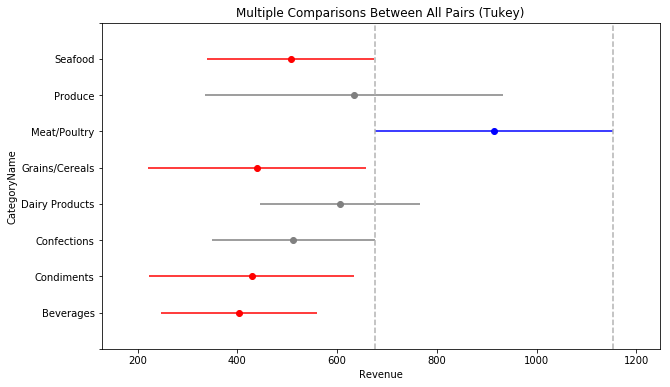

In [61]:
tukey_summer.plot_simultaneous(comparison_name='Meat/Poultry', ylabel='CategoryName', xlabel='Revenue').show()

#### Spring

In [62]:
sm.stats.anova_lm(ols('Spring_Rev ~ CategoryName', data=spring).fit())

,df,sum_sq,mean_sq,F,PR(>F)
CategoryName,7.0,1.828522e+07,2.612174e+06,2.592158,0.012113
Residual,663.0,6.681198e+08,1.007722e+06,NaN,NaN


- #### The ANOVA test shows that the p-value is less than the defined alpha of .05, this means that we reject the null hypothesis and accept the alternative hypothesis that there is a difference in revenue in the spring season.
- #### To see where the differences are, the Tukey HSD test is used.

In [63]:
tukey_spring = pairwise_tukeyhsd(spring['Spring_Rev'], spring['CategoryName'])
tukey_spring.summary()

group1,group2,meandiff,lower,upper,reject
Beverages,Condiments,-202.9509,-644.3146,238.4128,False
Beverages,Confections,-59.9398,-471.8783,351.9987,False
Beverages,Dairy Products,-9.8733,-399.2246,379.478,False
Beverages,Grains/Cereals,-193.6672,-686.7294,299.3949,False
Beverages,Meat/Poultry,233.8841,-297.4554,765.2235,False
Beverages,Produce,161.1216,-345.7439,667.9872,False
Beverages,Seafood,-349.487,-746.5406,47.5666,False
Condiments,Confections,143.0111,-329.5716,615.5938,False
Condiments,Dairy Products,193.0776,-259.9517,646.1069,False
Condiments,Grains/Cereals,9.2837,-535.4652,554.0326,False


/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


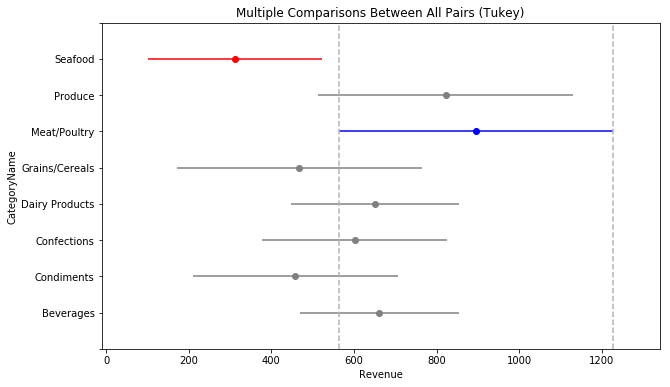

In [64]:
tukey_spring.plot_simultaneous(comparison_name='Meat/Poultry', ylabel='CategoryName', xlabel='Revenue').show()

#### Winter

In [65]:
sm.stats.anova_lm(ols('Winter_Rev ~ CategoryName', data=winter).fit())

,df,sum_sq,mean_sq,F,PR(>F)
CategoryName,7.0,2.857973e+07,4.082818e+06,2.859114,0.006068
Residual,625.0,8.925009e+08,1.428001e+06,NaN,NaN


- #### The ANOVA test shows that the p-value is less than the defined alpha of .05, this means that we reject the null hypothesis and accept the alternative hypothesis that there is a difference in revenue in the winter season.
- #### To see where the differences are, the Tukey HSD test is used.

In [66]:
tukey_winter = pairwise_tukeyhsd(winter['Winter_Rev'], winter['CategoryName'])
tukey_winter.summary()

group1,group2,meandiff,lower,upper,reject
Beverages,Condiments,-344.9305,-945.8644,256.0035,False
Beverages,Confections,-448.7328,-927.0692,29.6036,False
Beverages,Dairy Products,-246.8291,-743.5134,249.8553,False
Beverages,Grains/Cereals,-377.5594,-947.6017,192.4828,False
Beverages,Meat/Poultry,161.3873,-418.0777,740.8524,False
Beverages,Produce,-305.1361,-976.3859,366.1137,False
Beverages,Seafood,-488.8957,-995.9087,18.1173,False
Condiments,Confections,-103.8023,-708.8429,501.2383,False
Condiments,Dairy Products,98.1014,-521.5467,717.7495,False
Condiments,Grains/Cereals,-32.629,-712.4941,647.2362,False


/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


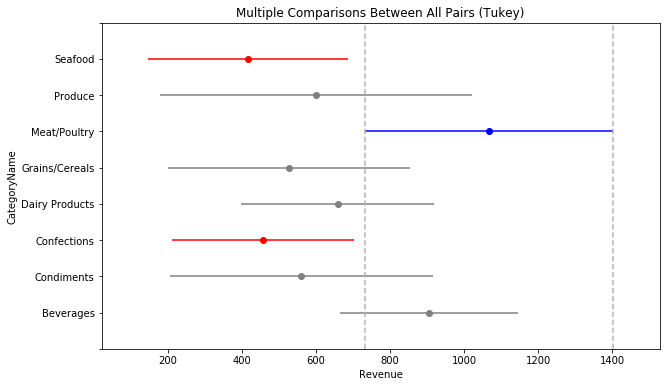

In [67]:
tukey_winter.plot_simultaneous(comparison_name='Meat/Poultry', ylabel='CategoryName', xlabel='Revenue').show()

#### Fall

In [68]:
sm.stats.anova_lm(ols('Fall_Rev ~ CategoryName', data=fall).fit())

,df,sum_sq,mean_sq,F,PR(>F)
CategoryName,7.0,1.279856e+07,1.828365e+06,3.22437,0.002376
Residual,478.0,2.710479e+08,5.670457e+05,NaN,NaN


- #### The ANOVA test shows that the p-value is less than the defined alpha of .05, this means that we reject the null hypothesis and accept the alternative hypothesis that there is a difference in revenue in the fall season.
- #### To see where the differences are, the Tukey HSD test is used.

In [69]:
tukey_fall = pairwise_tukeyhsd(fall['Fall_Rev'], fall['CategoryName'])
tukey_fall.summary()

group1,group2,meandiff,lower,upper,reject
Beverages,Condiments,-89.4588,-503.7473,324.8298,False
Beverages,Confections,-194.3048,-560.2328,171.6232,False
Beverages,Dairy Products,27.8024,-328.4744,384.0792,False
Beverages,Grains/Cereals,-178.2699,-603.4464,246.9066,False
Beverages,Meat/Poultry,336.9413,-100.844,774.7266,False
Beverages,Produce,213.2121,-329.9498,756.3739,False
Beverages,Seafood,-196.6495,-559.1517,165.8526,False
Condiments,Confections,-104.846,-520.1627,310.4706,False
Condiments,Dairy Products,117.2612,-289.5776,524.0999,False
Condiments,Grains/Cereals,-88.8111,-557.1696,379.5473,False


/Volumes/Data/Users/jucabrera/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


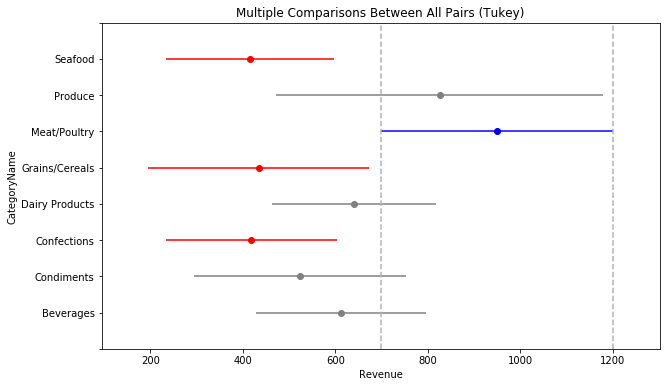

In [70]:
tukey_fall.plot_simultaneous(comparison_name='Meat/Poultry', ylabel='CategoryName', xlabel='Revenue').show()

### Interpretation of the findings

- For all four seasons, we rejected the null hypothesis and accepted the alternative hypothesis, meaning that there was a difference in revenue for certain categories throughout each season.
    - Summer:
        - Meat/Poultry generated the most revenue, but not statistically different from Produce, Dairy Products, and confections.
        - Beverages generated the least revenue, but not statistically different from the other categories other than Meat/Poultry.
    - Spring:
        - Meat/Poultry and Produce generated the most revenue, but not statistically different from any other category other than Seafood.
        - Seafood genterated the least revenue, but not statistically different from the other categories other than Meat/Poultry.
    - Winter:
        - Meat/Poultry generated the most revenue, but not statistically different from any other category other than Seafood and Confections.
        - Beverages was the next category that generated the most revenue.
    - Fall:
        - Meat/Poultry and Produce generated the most revenue, but not statistically different from any other category other than Seafood, Grains/Cereals, and Confections.
- Overall, the spring season seems to have the highest overall revenue for all categories. 
- Meat/Poultry is in high demand throughout all seasons and seafood is always least sought after category except in the summer.  This could be because the places that Northwind is getting their seafood supplies don't have the capabilities to provide fresh seafood -- weather.  Another category that remains in the bottom is Grains/Cereals.
- Suggestion: To increase sales of Seafood during the other seasons, Northwind should seek out suppliers that can provide fresh seafood from the warm regions.  